$\DeclareMathOperator*{\argmin}{arg\,min}$

I got introduced to the concept of [convex optimization](https://en.wikipedia.org/wiki/Convex_optimization) after viewing [Stephen P. Boyd](http://stanford.edu/~boyd/)'s lecture vidoes on the topic from the [Machine Learning Summer School 2015 in Tubingen](http://mlss.tuebingen.mpg.de/2015/speakers.html). Prof. Boyd has a very engaging style of explaining the topic. His lectures also included some code samples using the [CVXPY library](http://www.cvxpy.org/en/latest/), which was developed in his lab. After finishing the lectures, I decided to give the library a try and put to test some of Prof. Boyd's claims of solving the convex optimization problem by not caring about the solver -- or as he exclaims multiple times during the lectures -- "None of your goddamn business". 

## Convex optimization

I will not go into the details of convex optimization but will just try to explain it from the perspective of optimization and convex functions.

In optimization the goal is to find the arguments $\theta$ which maximize or minimize a given function $f(\theta)$. The function $f(\theta)$ can be any complex entity e.g. the average sales per day of a given company under some constraints such as the number of units which can be produced or sold should be less than a threshold. More formally, the goal is to find $\theta = \argmin_{\theta}{f(\theta)}$ if the function needs to be minimized. 

In convex optimization we put a condition on the allowed family of functions to be optimized. The condition is that the functions should be [convex](https://en.wikipedia.org/wiki/Convex_function) i.e. they should have only one global extremum (either maxima or minima). This yields very nice properties for creating efficient optimization algorithms for such functions. 

Ofcourse, for any one who has worked in data analysis or machine learning convex functions are not anything new. Infact, one of the most populars convex functions are the popular loss functions used in linear regression forumations, e.g. 

- $f(\theta) = (y - (\theta{x}))^2$ also known as the squared loss function
- $f(\theta) = -(y\log(\sigma(\theta{x})) + (1-y)\log(1-\sigma(\theta{x})))$ also known as the logistic loss or the cross entropy loss function used in binary classification settings


### A note on gradient based methods for optimizing convex functions

Although, most of these functions are these days optimized using the popular gradient based methods - which basically move the parameters in the direction of the steepest ascent/descent. However, one of the caveats of using gradient based methods is their pre-requirements for the functions to be differentiable everywhere in the parameter space. This means that gradient descent will not work for convex functions which are non-differentiable e.g. $f(x) = \max\limits_{i}(a_{i}*x+b_i)$. However, there do exist other methods for fining the extremum of these functions. But the most important thing is that the problem is a convex optimization problem and that is what guarentees it to have a unique extremum. So knowing how to solving it is -- "None of your goddamn business" -- as Prof. Boyd will say. 

## CVXPY

CVXPY actually implements many of those algorithms which are needed for solving a convex optimization problem. Another, great thing about the library is that it will analyze a given problem form and use a techniqe called **[Disciplined Convex Programming (DCP)](http://dcp.stanford.edu/home)** to identify if it is a convex optimization problem or not. Infact, there is a [DCP analyzer page](http://dcp.stanford.edu/analyzer) by Prof. Boyd's lab which allows you to input an optimization function and it will output if it is a convex problem or not. 

In the following lines I will use this library to show how easy it is to solve the convex optimization problem using CVXPY. I am using the anaconda distribution for installing this library and its related packages. 

In [1]:
%matplotlib inline

import cvxpy as cvx
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

sns.set_context("paper")
sns.set_style("ticks")

np.random.seed(1337)

## Fitting a quadratic curve to data points

In the spirit of machine learning, I will use the example of fitting a quadratic curve to a set of data points. The data is generated by adding gaussian noise to points sampled from a quadratic curve $f(x) = a*x^2 + b*x + c$ and we have to find the set of points $a,b,c$ which fit the data best. First let us look at the data and the original curve.

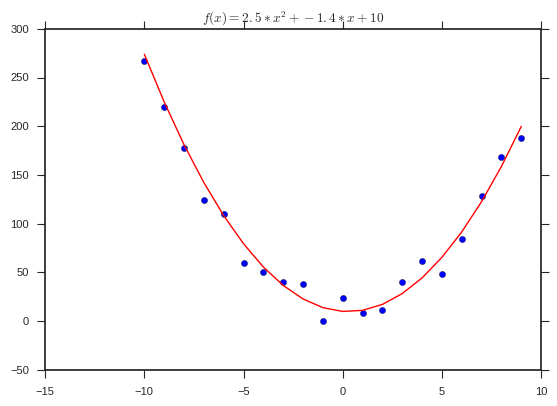

In [2]:
a,b,c = 2.5,-1.4,10
x = np.arange(-10,10)
y_orig = a*x**2 + b*x + c
y = y_orig + np.random.randn(x.shape[0])*10
plt.scatter(x,y)
plt.plot(x,y_orig,'-r',lw=1)
plt.title("$f(x) = %s*x^2 + %s*x + %s$" % (a,b,c))

## Defining the convex optimization problem in CVXPY

Now we are going to define the convex optimization problem which will give us the parameters which minimizes the mean squared loss (defined using the norm function in CVXPY). The following cell will define the variables which need to be optimized as well as the function to optimize along with some L1 regularization constraints. Finally, we will wrap the expression to optimize in a cvx.Problem object and then call solve. That is it.

In [3]:
a_bar = cvx.Variable()
b_bar = cvx.Variable()
c_bar = cvx.Variable()
C=1e-3
loss = cvx.norm(a_bar*x**2 + b_bar*x + c_bar - y)
reg = cvx.norm(a_bar,1) + cvx.norm(b_bar,1)
prob = cvx.Problem(cvx.Minimize(loss/x.shape[0] + C*reg))
prob.solve()

2.364341360670563

Calling `prob.solve()` finds the solution to the problem and returns the minimum value of the function. Furthermore, the values of the parameters for which the solution is reached are stored in the `value` property of each `cvx.Variable` object. 

In [4]:
print "a_bar=%s, b_bar=%s, c_bar=%s" % (a_bar.value, b_bar.value, c_bar.value)
print "a=%s, b=%s, c=%s" % (a, b, c)

a_bar=2.41662949138, b_bar=-1.03057743203, c_bar=11.1312608782
a=2.5, b=-1.4, c=10


As we can observe that the optimal values found by the solves are quite close to the original values used for generating the data points. Finally, we can see how the optimal curve fits the data points and how does it compare to the original curve. 

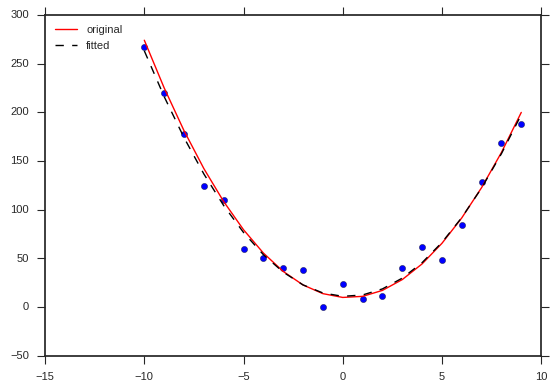

In [5]:
y_pred = a_bar.value*x**2 + b_bar.value*x + c_bar.value
plt.scatter(x,y)
plt.plot(x,y_orig,'-r',lw=1, label="original")
plt.plot(x,y_pred,'--k',lw=1, label="fitted")
plt.legend(loc="upper left")

## Contour of the parameter space

Now let us examine how the contour of the parameter space looks for the 2 parameters $a, b$ (I have kept $c$ fixed to its original value to visualize the surface on the 2D plane). 

In [6]:
#a,b,c = 2.5,-1.4,10
a_range = np.arange(1,5,1e-2)
b_range = np.arange(-10,10,1e-1)
print a_range.shape, b_range.shape
A, B = np.meshgrid(a_range, b_range)
print A.shape, B.shape
Z = np.zeros_like(A)
for i, ai in enumerate(a_range):
    for j, bj in enumerate(b_range):
        Z[j,i] = np.mean(np.square(ai*x**2 + bj*x + c - y))
Z.shape

(400,) (200,)
(200, 400) (200, 400)


(200, 400)

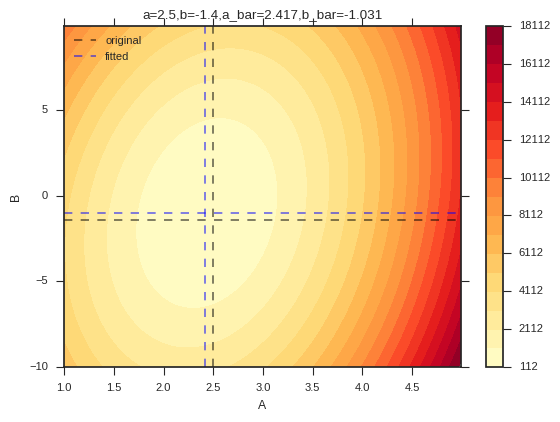

In [7]:
levels = np.arange(Z.min(), Z.max(), 1000)  # Boost the upper limit to avoid truncation errors.
norm = cm.colors.Normalize(vmax=np.abs(Z).max(), vmin=np.abs(Z).min())
plt.figure()
cset1 = plt.contourf(A, B, Z,levels,
                 cmap='YlOrRd',
                 norm=norm,
                 )
plt.colorbar(cset1)
plt.xlabel("A")
plt.ylabel("B")
plt.axhline(y=b,linestyle="--", color="k", alpha=0.5, label="original")
plt.axvline(x=a, linestyle="--", color="k", alpha=0.5)
plt.axhline(y=b_bar.value,linestyle="--", color="b", alpha=0.5, label="fitted")
plt.axvline(x=a_bar.value, linestyle="--", color="b", alpha=0.5)
plt.title("a=%s,b=%s,a_bar=%.3f,b_bar=%.3f" % (a,b,a_bar.value, b_bar.value))
plt.legend(loc="upper left")

We do observe that the optimal parameters returned by CVXPY are in the neighborhood of the minimum cost region and close to the original parameter values.

## Non linear curve

Now let us take the case of a non-linear system where the errors are not distributed normally, but are transformed by the exponential function. Again our parameters are $a,b,c$ and the data points are sampled from the curve $f(X)=e^{a*X^2+b*X+C}$. The function looks as follows:

(200,) (200,) (200,)


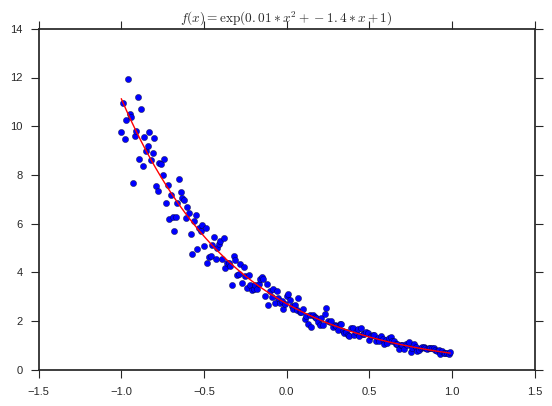

In [8]:
a,b,c = 1e-2,-1.4,1
x = np.arange(-1,1,0.01)
y_orig = np.exp(a*x**2 + b*x + c)
y = np.exp(a*x**2 + b*x + c + np.random.randn(x.shape[0])*1e-1)
plt.scatter(x,y)
plt.plot(x,y_orig,'-r',lw=1)
plt.title("$f(x) = \exp(%s*x^2 + %s*x + %s)$" % (a,b,c))
print x.shape, y.shape, y_orig.shape

Now the original problem of fitting the data points to the exponential curve is not convex, because of it not following the DCP rules. This can also be inspected by using the `is_dcp()` function of a problem object. Furthermore, the curvature of the loss object is also unknown as identified by CVXPY. Let us try it out:

In [9]:
a_bar = cvx.Variable()
b_bar = cvx.Variable()
c_bar = cvx.Variable()
C=1e-3
loss = cvx.norm(cvx.exp(a_bar*x**2 + b_bar*x + c_bar) - y)
reg = cvx.norm(a_bar, 1) + cvx.norm(b_bar,1)
prob = cvx.Problem(cvx.Minimize(loss/x.shape[0] + C*reg))

print "Is the problem DCP: ", prob.is_dcp()
print "Problem curvature: ", loss.curvature
print "Problem sign: ", loss.sign
try:
    prob.solve()
except cvx.error.DCPError as e:
    print e

Is the problem DCP:  False
Problem curvature:  UNKNOWN
Problem sign:  POSITIVE
Problem does not follow DCP rules.


We can actually convert the problem to DCP by doing a log transform on RHS and LHS of the equation. This effectively converts the problem into the earlier quadratic curve fitting problem. CVXPY also tells us that this problem does follow the DCP rules and has a convex curvature. 

In [10]:
a_bar = cvx.Variable()
b_bar = cvx.Variable()
c_bar = cvx.Variable()
C=1e-3
loss = cvx.norm(a_bar*x**2 + b_bar*x + c_bar - np.log(y))
reg = cvx.norm(a_bar, 1) + cvx.norm(b_bar,1)
prob = cvx.Problem(cvx.Minimize(loss/x.shape[0] + C*reg))
print "Is the problem DCP: ", prob.is_dcp()
print "Problem curvature: ", loss.curvature
print "Problem sign: ", loss.sign
print prob.solve()
print "a_bar=%s, b_bar=%s, c_bar=%s" % (a_bar.value, b_bar.value, c_bar.value)
print "a=%s, b=%s, c=%s" % (a, b, c)

Is the problem DCP:  True
Problem curvature:  CONVEX
Problem sign:  POSITIVE
0.00808430036247
a_bar=6.27991593202e-07, b_bar=-1.37453574727, c_bar=1.00493142834
a=0.01, b=-1.4, c=1


We can see that the parameters of the optimal curve found by CVXPY are quite close to the original parameters. Now we can plot the optimized curve versus the original curve. 

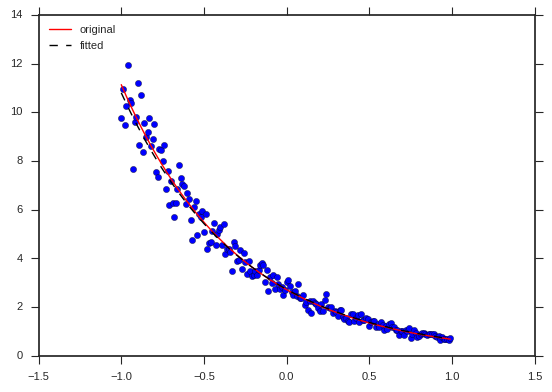

In [11]:
y_pred = np.exp(a_bar.value*x**2 + b_bar.value*x + c_bar.value)
plt.scatter(x,y)
plt.plot(x,y_orig,'-r',lw=1, label="original")
plt.plot(x,y_pred,'--k',lw=1, label="fitted")
plt.legend(loc="upper left")

The fitted curves also match quite well. Let us explore the parameter space with respect to the loss function as we did earlier. We know that the parameter space should be quite similar to the original space as the final loss function is also quadratic.

In [12]:
#a,b,c = 1e-2,-1.4,1
a_range = np.arange(-4,2,1e-2)
b_range = np.arange(-5,5,1e-1)
print a_range.shape, b_range.shape
A, B = np.meshgrid(a_range, b_range)
print A.shape, B.shape
Z = np.zeros_like(A)
for i, ai in enumerate(a_range):
    for j, bj in enumerate(b_range):
        Z[j,i] = np.mean(np.square(ai*x**2 + bj*x + c - np.log(y)))
Z.shape

(600,) (100,)
(100, 600) (100, 600)


(100, 600)

In [13]:
Z.min(), Z.max()

(0.0091438091332204201, 16.623137689495856)

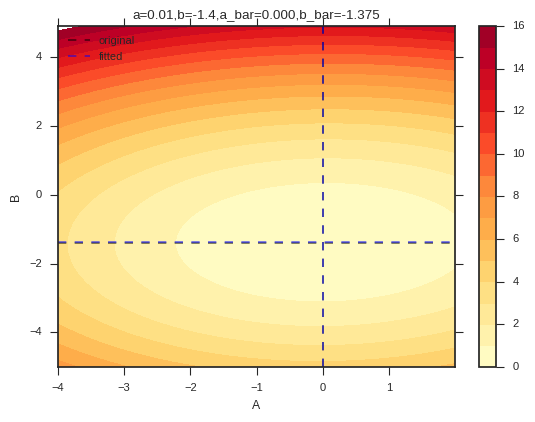

In [14]:
levels = np.arange(Z.min(), Z.max(), 1)  # Boost the upper limit to avoid truncation errors.
norm = cm.colors.Normalize(vmax=np.abs(Z).max(), vmin=np.abs(Z).min())
plt.figure()
cset1 = plt.contourf(A, B, Z,levels,
                 cmap='YlOrRd',
                 norm=norm,
                 )
plt.colorbar(cset1)
plt.xlabel("A")
plt.ylabel("B")
plt.axhline(y=b,linestyle="--", color="k", alpha=0.5, label="original")
plt.axvline(x=a, linestyle="--", color="k", alpha=0.5)
plt.axhline(y=b_bar.value,linestyle="--", color="b", alpha=0.5, label="fitted")
plt.axvline(x=a_bar.value, linestyle="--", color="b", alpha=0.5)
plt.title("a=%s,b=%s,a_bar=%.3f,b_bar=%.3f" % (a,b,a_bar.value, b_bar.value))
plt.legend(loc="upper left")

Finally, we see that the original and the optimal parameter values found by CVXPY again fall in the same region and are quite close to each other. So, a slight transformation of the problem converted it into a convex optimization problem, which was quickly solved by CVXPY.

## Closing thoughts

I feel the field of convex optimization is quite fascinating and allows us a different perspective to machine learning practitioner who mostly deal with fitting models to data. The [CVXPY examples](http://www.cvxpy.org/en/latest/examples/index.html) and Prof. Boyd's talk include many other interesting applications of convex optimization like in [image inpainting using total variation](http://nbviewer.jupyter.org/github/cvxgrp/cvxpy/blob/master/examples/notebooks/WWW/tv_inpainting.ipynb) and my personal favorite [Quantile regression](http://nbviewer.jupyter.org/github/cvxgrp/cvx_short_course/blob/master/applications/quantile_regression.ipynb), many of these examples talk about optimization in general without formulating the problem as that of fitting a model to data. Finally, I am not an expert in convex optimization and this post was an attempt to learn about this domain, try out the CVXPY library, and apply it to some toy problems I am interested in. If you can find more exciting use cases of convex optimization or CVXPY, feel free to post in comments.